In [1]:
# Setting auto reloading for imported modules
%load_ext autoreload
%autoreload 2

In [36]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from auxiliary_functions import Utils
from matplotlib.ticker import FormatStrFormatter

In [3]:
utils = Utils()

In [4]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

**Data preprocessing**
<br>
*Duplicates*

In [6]:
df.shape

(891, 12)

In [7]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [8]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates = df[df.duplicated(keep=False)]
    if duplicates.empty:
        print('There are no duplicate entries in this dataset.')
    else:
        print(f'Number of duplicate entries in this dataset: {len(duplicates)}')
        print(f'Duplicated rows:\n {duplicates}')

check_duplicates(df)

There are no duplicate entries in this dataset.


**Data preprocessing**
<br>
*Handle Missing Values*

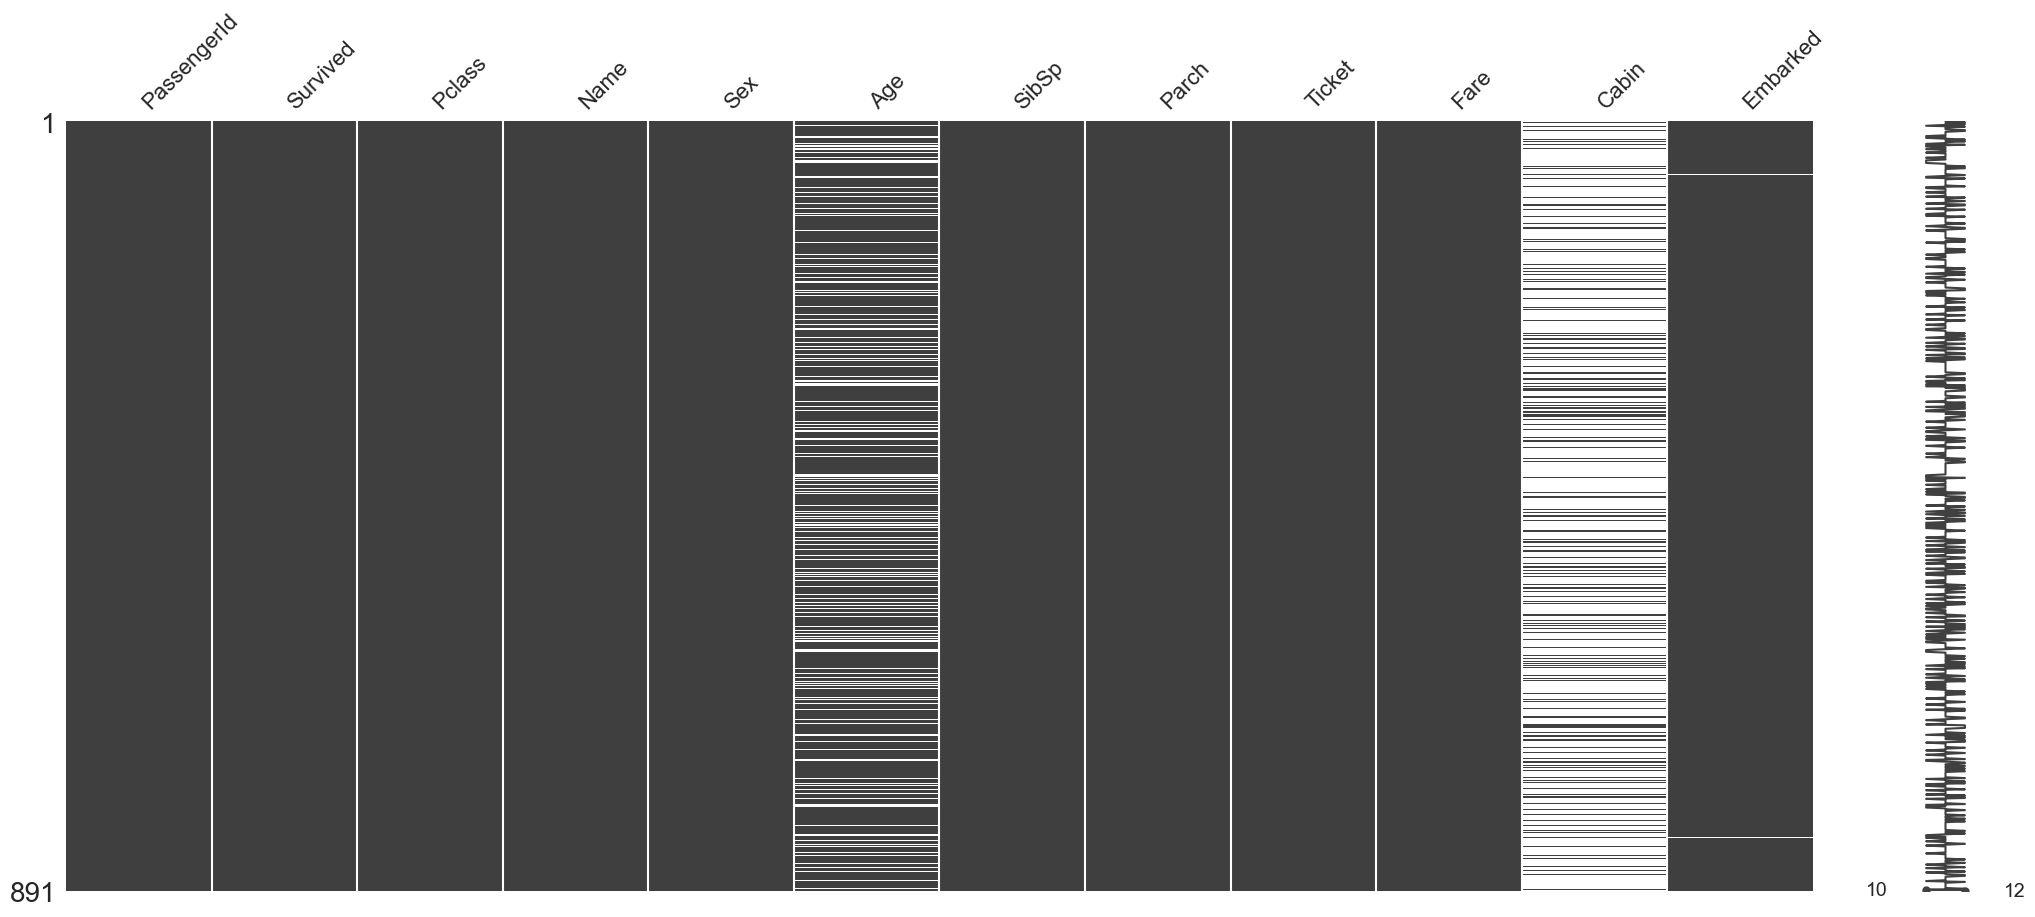

In [9]:
msno.matrix(df);

In [10]:
utils.missing_values_percentage(df)

Complete rows in percentage: 20.54%
Missing values in percentage:
Cabin       77.10
Age         19.87
Embarked     0.22
dtype: float64


In [11]:
df.Cabin.value_counts(dropna=False)

Cabin
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

In [12]:
df[df.Cabin.notna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [13]:
df_clean = df.copy()
df_clean['cabin_letter_code'] = df_clean['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'N/A')
df_clean['no_of_cabins'] = df_clean['Cabin'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
df_clean = df_clean.drop(columns=['Cabin'], axis=1)
df_clean['cabin_letter_code'].value_counts()

cabin_letter_code
N/A    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: count, dtype: int64

In [14]:
utils.missing_values_percentage(df_clean)

Complete rows in percentage: 79.91%
Missing values in percentage:
Age         19.87
Embarked     0.22
dtype: float64


In [15]:
df_clean['Age'].value_counts(dropna=False)

Age
NaN      177
24.00     30
22.00     27
18.00     26
28.00     25
        ... 
36.50      1
55.50      1
0.92       1
23.50      1
74.00      1
Name: count, Length: 89, dtype: int64

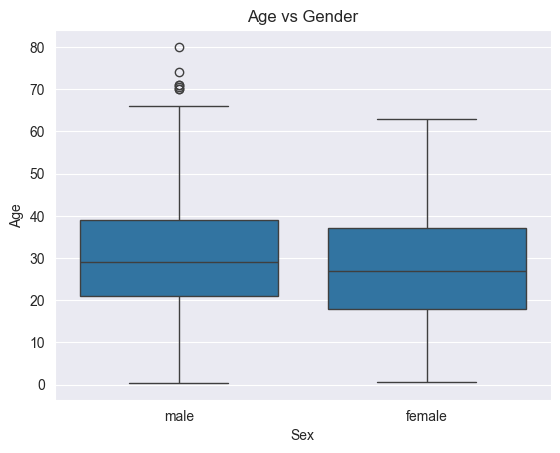

Mean age for gender groups:
Sex
female    28.0
male      31.0
Name: Age, dtype: float64


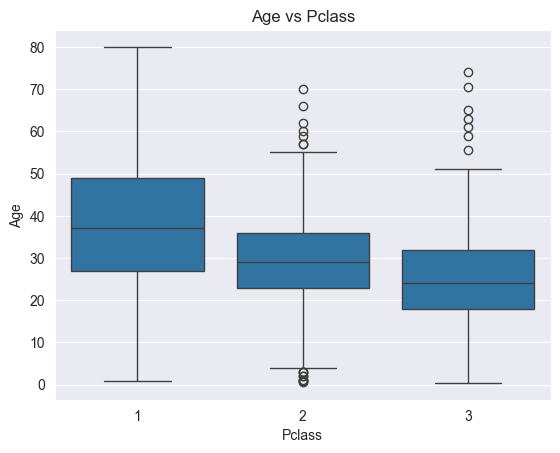

Mean age for passenger class groupsPclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64


In [16]:
# Imputation Based on Segmentation
sns.boxplot(x='Sex', y='Age', data=df_clean)
plt.title('Age vs Gender')
plt.show()
mean_age_by_gender = round(df.groupby('Sex')['Age'].mean(), 0)
print(f"Mean age for gender groups:\n{mean_age_by_gender}")

sns.boxplot(x='Pclass', y='Age',data=df_clean)
plt.title('Age vs Pclass')
plt.show()
mean_age_by_pclass = round(df.groupby('Pclass')['Age'].mean(), 0)
print(f"Mean age for passenger class groups{mean_age_by_pclass}")

In [17]:
mean_age_by_gender = round(df.groupby(['Sex', 'Pclass'])['Age'].mean(), 0)
print(mean_age_by_gender)

Sex     Pclass
female  1         35.0
        2         29.0
        3         22.0
male    1         41.0
        2         31.0
        3         27.0
Name: Age, dtype: float64


In [18]:
df_clean['Age'] = df_clean.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))
df_clean.Age.describe()

count    891.000000
mean      29.318643
std       13.281103
min        0.420000
25%       21.750000
50%       26.507589
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [19]:
utils.missing_values_percentage(df_clean)

Complete rows in percentage: 99.78%
Missing values in percentage:
Embarked    0.22
dtype: float64


In [20]:
df_clean['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [21]:
embarked_mode = df_clean['Embarked'].mode()[0]
df_clean['Embarked'] = df_clean['Embarked'].fillna(embarked_mode)
utils.missing_values_percentage(df_clean)

Complete rows in percentage: 100.00%
Missing values in percentage:
Series([], dtype: float64)


In [22]:
df_clean['Embarked'].value_counts(dropna=False)

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [23]:
df_clean.dtypes

PassengerId            int64
Survived               int64
Pclass                 int64
Name                  object
Sex                   object
Age                  float64
SibSp                  int64
Parch                  int64
Ticket                object
Fare                 float64
Embarked              object
cabin_letter_code     object
no_of_cabins           int64
dtype: object

**Data preprocessing**
<br>
*Data Cleaning/Outliers*

In [24]:
df_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_letter_code,no_of_cabins
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,N/A,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,N/A,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,N/A,0


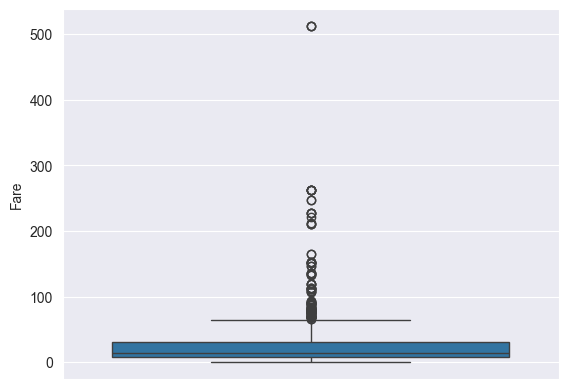

In [25]:
sns.boxplot(df_clean['Fare'])
plt.show()

In [26]:
outliers_fare, fare_boundaries = utils.find_outliers_iqr(df=df_clean, column='Fare')
print(outliers_fare['Survived'].value_counts())
outliers_fare

Survived
1    79
0    37
Name: count, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_letter_code,no_of_cabins
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,C,1
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000000,3,2,19950,263.0000,S,C,3
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,34.611765,1,0,PC 17569,146.5208,C,B,1
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000000,1,0,PC 17604,82.1708,C,N/A,0
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000000,1,0,PC 17572,76.7292,C,D,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,847,0,3,"Sage, Mr. Douglas Bullen",male,26.507589,8,2,CA. 2343,69.5500,S,N/A,0
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,34.611765,1,0,17453,89.1042,C,C,1
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.000000,1,1,36928,164.8667,S,N/A,0
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,21.750000,8,2,CA. 2343,69.5500,S,N/A,0


Outliers in 'Fare' column should be kept as they corresponds with the survival

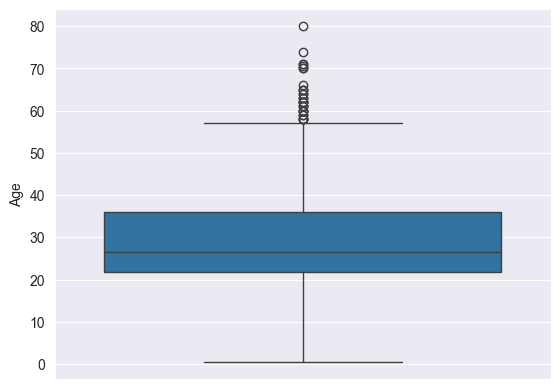

In [27]:
sns.boxplot(df_clean['Age'])
plt.show()

In [28]:
age_outliers, age_boundaries = utils.find_outliers_iqr(df=df_clean, column='Age')
print(age_outliers['Survived'].value_counts())
age_outliers

Survived
0    23
1    10
Name: count, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_letter_code,no_of_cabins
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,S,C,1
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,S,N/A,0
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,C,B,1
94,95,0,3,"Coxon, Mr. Daniel",male,59.0,0,0,364500,7.2500,S,N/A,0
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,C,A,1
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,Q,N/A,0
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,S,B,1
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,C,B,1
232,233,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,237442,13.5000,S,N/A,0
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,S,C,1


Outliers in 'Age' column should be capped as they do have weak correspond rate with the survival

In [29]:
df_clean['Age'] = np.where(df['Age'] > age_boundaries[1], age_boundaries[1], df['Age'])

**Exploratory Data Analysis**

In [30]:
df_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_letter_code,no_of_cabins
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,N/A,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,N/A,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,N/A,0


In [85]:
categorical_features = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'cabin_letter_code']
continuous_features = ['Age', 'Fare']

Univariate Analysis of the Target Feature

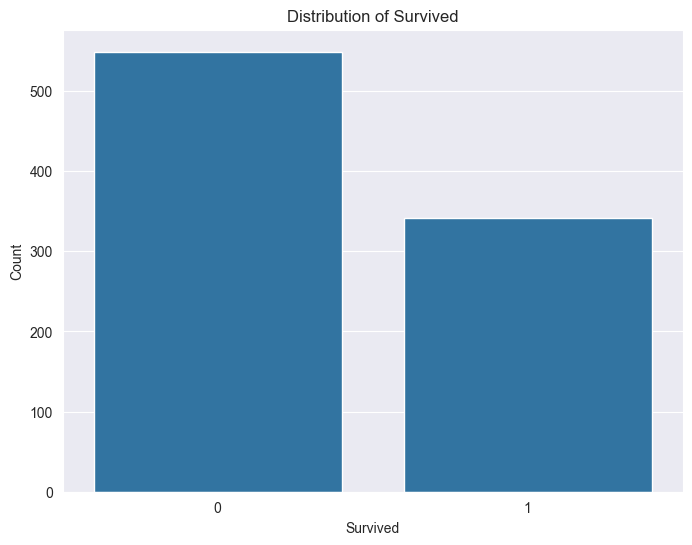

In [87]:
utils.create_bar_plot(df=df_clean, column='Survived')

Univariate Analysis of Other Features

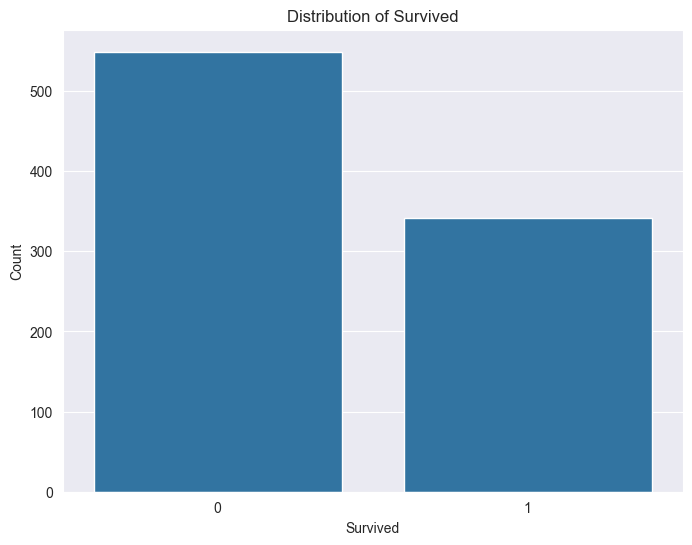

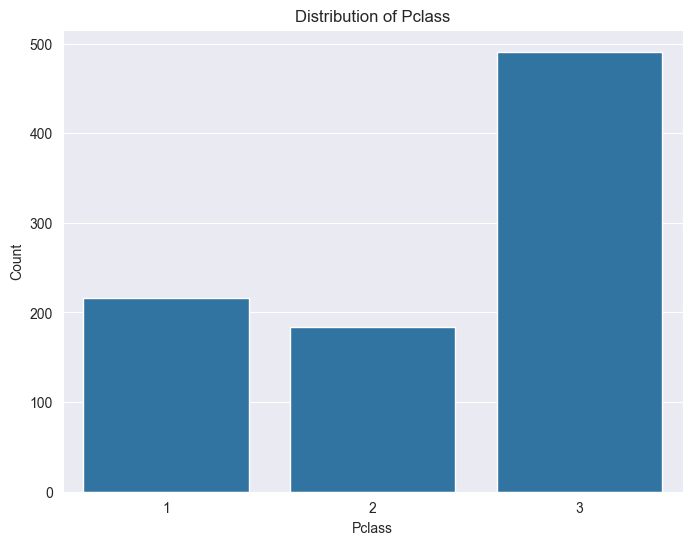

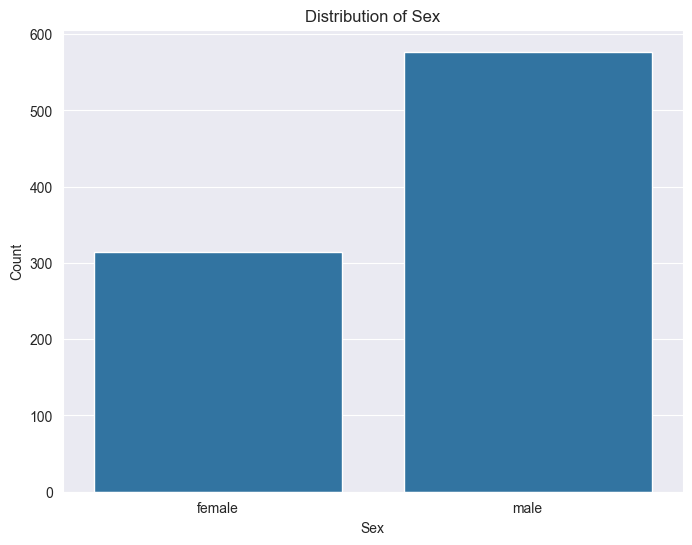

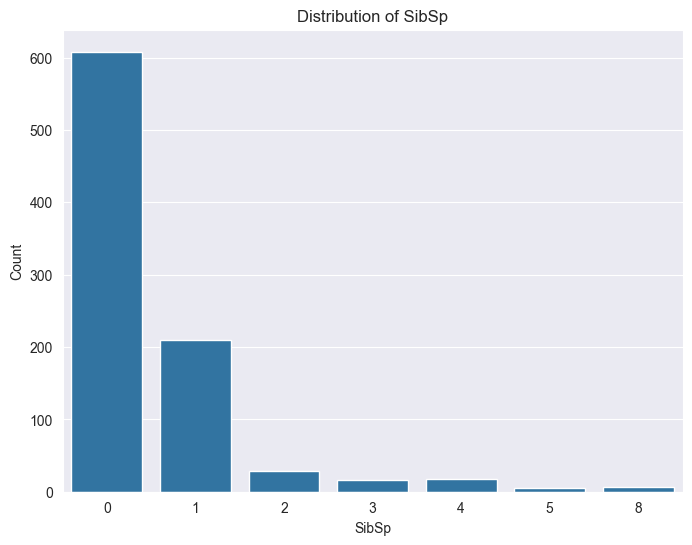

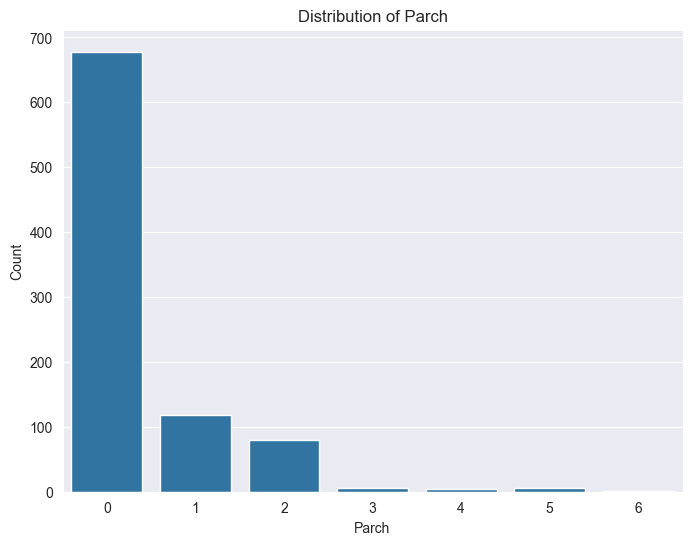

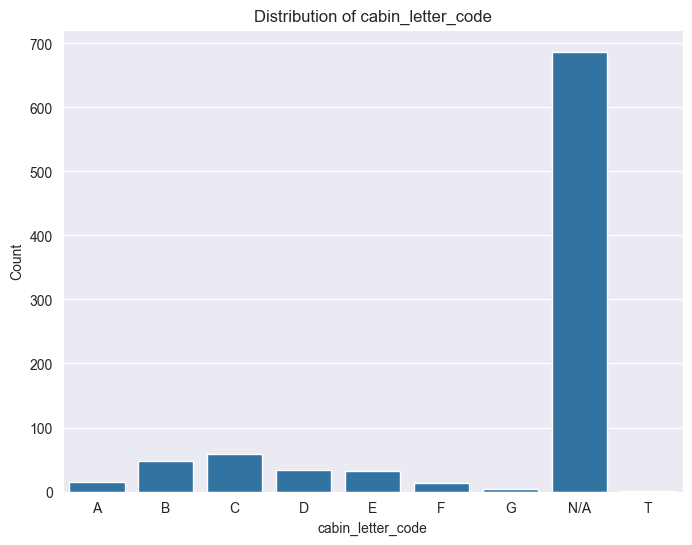

In [88]:
for feature in categorical_features:
    utils.create_bar_plot(df=df_clean, column=feature)

Bivariate Analysis Between Features and Target Feature

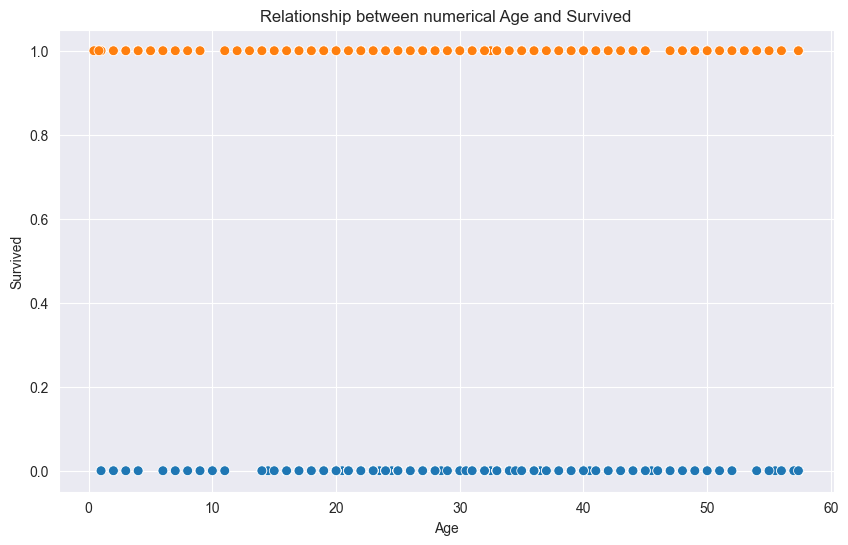

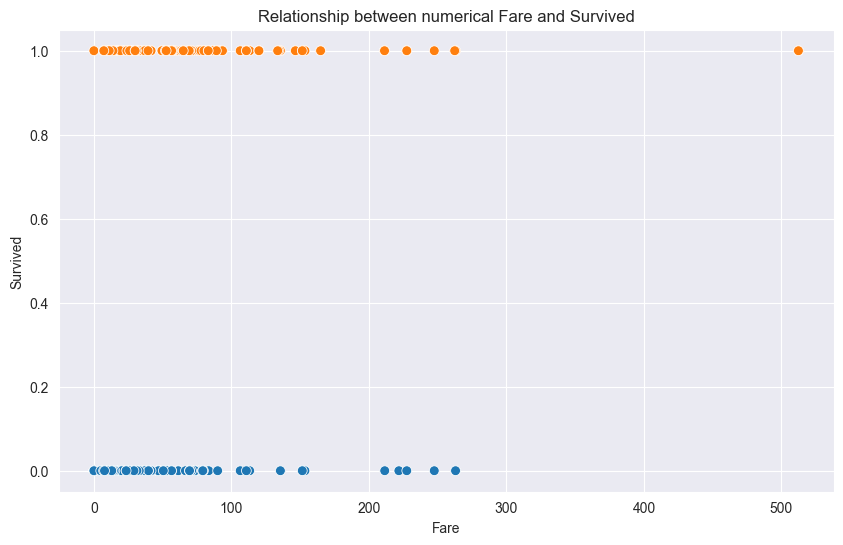

In [90]:
for feature in df.columns.tolist():
    if feature in continuous_features:
        utils.create_scatter_plot(df=df_clean, feature=feature, target_feature='Survived')